# Introduction: loading, slicing, dicing model output

This tutorial is designed to help new users get to grips with the COSIMA Cookbook.

The COSIMA Cookbook is collection of recipes for analysing ocean and sea ice model output, using a common method of loading the output.

The tutorial requires:
 * Access to the ACCESS-NRI Intake Catalog (through project `xp65`).
 * Ability to open a Jupyter notebook on the NCI's Gadi HPC (e.g., via the ARE).
 * Access an appropriate set of `conda` packages to load the appropriate python libraries (such as through the `xp65` conda packages).

**Before starting,** load in some standard libraries that you are likely to need:

In [1]:
# To start a dask cluster
from dask.distributed import Client
# For plotting
import matplotlib.pyplot as plt
# For oceanographic colormaps
import cmocean as cm
# For numerical operations
import numpy as np

Start a cluster with multiple cores

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41137,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41421,Total threads: 1
Dashboard: /proxy/40611/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35345,


In addition, you **always** need to load the `intake` module. 
This provides functions that we use to load data via the ACCESS-NRI Intake Catalog:

In [3]:
import intake

## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:

* Provide examples of commonly used analyses;
* Write efficient, well-documented, openly accessible code;
* Encourage community contributions to the code;
* Ensure analyses results are reproducible;
* Carry out analysis using directly the model output, minimising creation of intermediate files;
* Find methods to deal with the memory limitations when analysing high-resolution model output.

### 1.1 A database of experiments
The COSIMA Cookbook relies on a database of experiments (let's call it a datastore) in order to load model output. This datastore effectively holds metadata for each experiment, as well as variable names, data ranges and so on. 

**NCI Projects**: Access to COSIMA ocean-sea ice model output requires that you are a member of NCI projects `xp65`, `ik11`, `cj50`, and `ol01`.

With that sorted out, there are three different ways for you to access the datastore:

1. Use the default ACCESS-NRI catalog, which is periodically refreshed automatically. This datastore includes many experiments stored in the COSIMA data directories on NCI under the projects mentioned above. The examples in this tutorial use this datastore.

2. Use another datastore that someone has made for you.

3. Make your own catalog, which is stored in your own path and includes only the experiments you are interested in. Please refer to the [`Make_Your_Own_Intake_Datastore`](https://cosima-recipes.readthedocs.io/en/latest/01-Cooking-Lessons-101/02-Advanced/Make_Your_Own_Intake_Datastore.html) tutorial for instructions on how to create this datastore.

To access the default datastore, you need to load it each time you fire up a notebook:

In [4]:
catalog = intake.cat.access_nri

### 1.2 Inbuilt Catalog Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets.  The following functions query and display the data available in the datastore, without loading the data itself.

`catalog` lists all of the experiments and variables that are included in the datastore. The format is mostly self-explanatory, but the list is huge (and noth particularly useful):

In [5]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_Control,{ACCESS-OM2-01},"{0.1° ACCESS-OM2 repeat year forcing control run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, sw_heat_on_nrho, temp_tendency, temp_vdiffuse_diff_cbt, mass_pmepr_on_nrho, evap, TLON..."
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, tarea, total_ocean_calving, temp_surface_ave, ty_trans, temp_tendency, temp_vdiffuse_diff_cbt, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_sur..."
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, tarea, total_ocean_calving, temp_surface_ave, ty_trans, temp_tendency, temp_vdiffuse_diff_cbt, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_sur..."
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{fx, 3mon, 3hr, 1day, 1mon}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, temp_tendency, TLON, evap, yt_ocean_sub01, st_edges_ocean, grid_xu_ocean, average_DT, ..."
01deg_jra55v13_ryf9091_easterlies_down10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica decreased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_surface_ave, yt_ocean, geo..."
01deg_jra55v13_ryf9091_easterlies_up10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_surface_ave, yt_ocean, geo..."
01deg_jra55v13_ryf9091_easterlies_up10_meridional,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_surface_ave, yt_ocean, geo..."
01deg_jra55v13_ryf9091_easterlies_up10_zonal,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, temp_yflux_adv, total_ocean_calving, tarea, temp_surface_ave, ty_trans, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_surface_ave, yt_ocean, geo..."
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}","{ocean, seaIce}","{1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, tarea, total_ocean_calving, temp_surface_ave, ty_trans, temp_tendency, temp_vdiffuse_diff_cbt, TLON, evap, st_edges_ocean, grid_xu_ocean, average_DT, salt_sur..."


Each line in the table above references a directory full of netCDF files with model output.

**The COSIMA cookbook philosophy is that you don't need to know about the directories in which these files are stored to be able to interrogate them or to load the data**.

However, with thousands of experiments in the datastore, the above table isn't so easy to understand. Luckily, we can refine our search to limit the experiments we see. For example, if we already know the name of the experiment we are after, we can specify it via:

In [6]:
catalog.search(name='025deg_jra55_ryf9091_gadi')

,model,description,realm,frequency,variable
name,,,,,
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1yr, 1mon, fx}","{shear_m, xt_ocean, total_ocean_evap, tarea, total_ocean_calving, temp_surface_ave, strtlty_m, ty_trans, snow_ai_m, TLON, st_edges_ocean, fcondtopn_ai_m, average_DT, salt_surface_ave, yt_ocean, ge..."


This is more useful, because it focusses just on the experiment I'm interested in -- and provides a list of all the variables available that experiment. It also gives a short description which is a nice way to explore which experiments might be available.

However, we may notice that the list of variables in the right-most column here is too long for this format. There are other ways to get hold of a list of all of these variables, such as:

In [7]:
variables = catalog.search(name='025deg_jra55_ryf9091_gadi').unique().variable
print(variables)

['shear_m', 'xt_ocean', 'total_ocean_evap', 'tarea', 'total_ocean_calving', 'temp_surface_ave', 'strtlty_m', 'ty_trans', 'snow_ai_m', 'TLON', 'st_edges_ocean', 'fcondtopn_ai_m', 'average_DT', 'salt_surface_ave', 'yt_ocean', 'geolon_t', 'uvel_m', 'divu_m', 'dzt', 'strcorx_m', 'total_ocean_pme_river', 'total_ocean_calving_melt_heat', 'st_ocean', 'vvel_m', 'xu_ocean', 'u', 'fsurfn_ai_m', 'Tair_m', 'frazil_m', 'total_ocean_runoff', 'albsni_m', 'rain_ai_m', 'flatn_ai_m', 'total_ocean_river_heat', 'ty_trans_int_z', 'fmelttn_ai_m', 'total_ocean_heat', 'alidr_ai_m', 'nv', 'total_ocean_salt', 'strintx_m', 'hs_m', 'strairy_m', 'average_T1', 'grid_xt_ocean', 'sea_levelsq', 'sw_edges_ocean', 'time_bounds', 'fsens_ai_m', 'snoice_m', 'ANGLET', 'evap_ai_m', 'kmt', 'sfc_salt_flux_ice', 'scalar_axis', 'flat_ai_m', 'pot_temp', 'ke_tot', 'salt', 'age_global', 'sfc_salt_flux_coupler', 'trsig_m', 'v', 'geolat_c', 'total_ocean_lw_heat', 'fresh_ai_m', 'fswthru_ai_m', 'fhocn_ai_m', 'NCAT', 'frazil_3d_int_z', 

See the [`ACCESS-NRI_Intake_Catalog`](https://cosima-recipes.readthedocs.io/en/latest/01-Cooking-Lessons-101/01-Basics/02-ACCESS-NRI_Intake_Catalog.html) for additional methods.

### 1.3 Loading data from an experiment

Python has many ways of reading data from a netCDF file... so we thought we would add another way. This is done via the `.to_dask()` function, which is the most commonly used function in the Cookbook. This function takes the output from a `catalog.search()` query to find a specific variable, and loads the files you need to create that variable.

Let's take now a little while to get to know how to load output. Most times, we need just three arguments: `experiment`, `variable`, and (in most cases) the `frequency` of the variable. 

In [8]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'temp_global_ave'

ds = catalog[experiment].search(variable=variable).to_dask(xarray_open_kwargs = dict(use_cftime=True))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


The above command returns an `xarray` dataset `ds`.

**Note 1**: it is possible to load several variables at once in this fashion and thus get a dataset with many variables (`variable=[variable_1, variable_2]`)

**Note 2**: the `xarray_open_kwargs = dict(use_cftime=True)` argument is only needed to suppress warnings for experiments which go outside the range of "normal" dates used by `np.datetime`

It's often easier to work with an `xarray` dataarray instead of a dataset. In that case, we can extract the dataarray that corresponds to the variable of our choice via:

In [9]:
ds['temp_global_ave']

<xarray.DataArray 'temp_global_ave' (time: 7800, scalar_axis: 1)> Size: 62kB
dask.array<concatenate, shape=(7800, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 8B 0.0
  * time         (time) object 62kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

We can see that this operation loaded the globally averaged potential temperature from the model output. The time axis runs from year 1900 to year 2459. For some variables (particularly 3D variables that might use a loooot of memory), we may prefer to restrict ourselves to a smaller time window:

In [10]:
ds['temp_global_ave'].sel(time=slice('2000-01-01', '2050-12-31'))

<xarray.DataArray 'temp_global_ave' (time: 612, scalar_axis: 1)> Size: 5kB
dask.array<getitem, shape=(612, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 8B 0.0
  * time         (time) object 5kB 2000-01-16 12:00:00 ... 2050-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load sea surface height (ssh) from an experiment (perhaps choose a 1° configuration for starters).

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` method does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


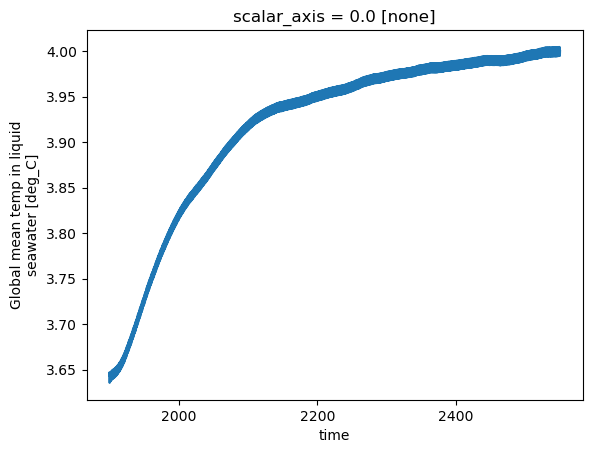

In [11]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'temp_global_ave'
ds = catalog[experiment].search(variable=variable).to_dask(xarray_open_kwargs = dict(use_cftime=True))
ds[variable].plot()

You can see that `xarray` has used the metada in its plot, correctly labeing the x-axis which time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

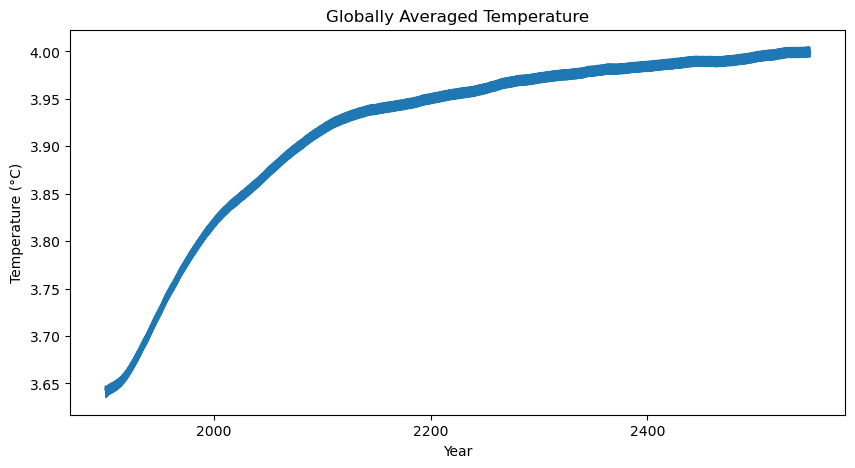

In [12]:
plt.figure(figsize=(10, 5))
ds[variable].plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature');

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it should plot. By way of example, let's load a single time slice of `surface_temp` and see how `.plot()` handles it: 

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


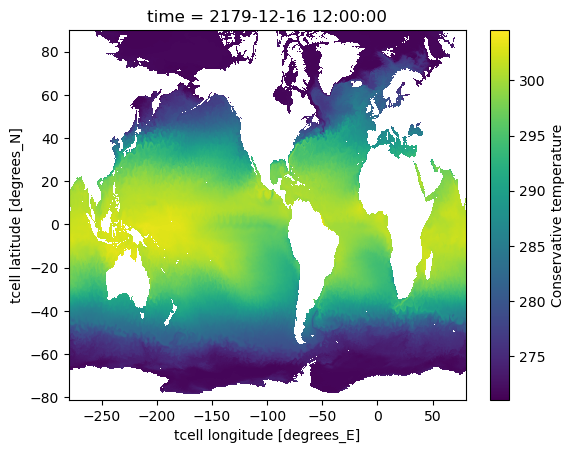

In [13]:
experiment = '01deg_jra55v13_ryf9091'
variable = 'surface_temp'
ds = catalog[experiment].search(variable=variable, frequency='1mon').to_dask()
temp = ds[variable].isel(time=-1).load()
temp.plot()

A few things you might notice here. Firstly, we didn't need to pass any `xarray_open_kwargs` in the `.to_dask()` function - because this experiment has a smaller date range (1900-2179). Second, we needed to specify the `frequency` - this is because this field is saved at both daily and monthly frequency, and they need dismabiguation. Also, even though this is an experiment at a 0.1° horizontal resolution for 280 years -- we can still load `ds`, because it's lazily loading (that is, it only loads the metadata). But before we plot, we need to select a single time level to ensure we don't run out of memory!

Again, we can customise this plot as we see fit:

Text(0.5, 1.0, 'Surface Temperature')

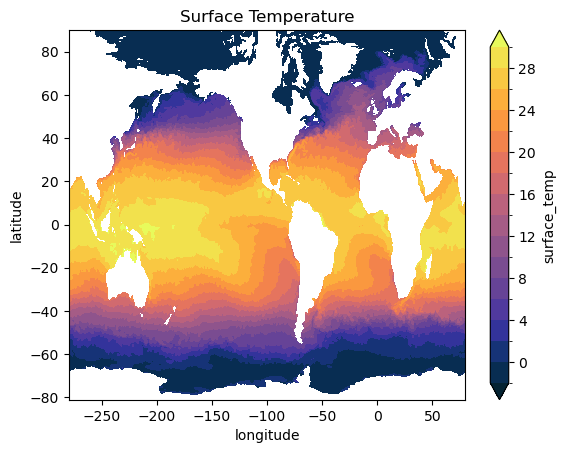

In [14]:
temp_C = temp - 273.15 # convert from Kelvin to Celsius
temp_C.plot.contourf(levels=np.arange(-2, 32, 2), cmap=cm.cm.thermal)

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Surface Temperature')

### 2.2 Slicing and dicing

There are two different ways of subselecting from a DataArray: `isel` and `sel`. The first of these two is selecting by index (the `i` stands for index). This means we specify the value of the index of the array. For the latter, we can specify the _value_ of the coordinate we want to select.

These two methods are demonstrated in the following example:

In [15]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'pot_rho_0' # potential density referenced to the surface

ds = catalog[experiment].search(variable=variable, frequency='1yr').to_dask(xarray_open_kwargs=dict(use_cftime=True))
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.Dataset> Size: 123GB
Dimensions:    (time: 396, st_ocean: 50, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * st_ocean   (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time       (time) object 3kB 1904-07-02 12:00:00 ... 2299-07-02 12:00:00
Data variables:
    pot_rho_0  (time, st_ocean, yt_ocean, xt_ocean) float32 123GB dask.array<chunksize=(1, 10, 216, 288), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-025
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['pot_rho_0']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  sea_water_age_since_surface_con...
    intake_esm_attrs:variable_cell_methods:   time: mean,,,,time: mean,,,,tim...
    intake_esm_attrs:variable_units:          yr,days,days since 1900-01-01 0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1yr.grid_xt_ocean:1440.gr...

In the above example, a 600-year dataset is loaded. You can see that potential density is a four dimensional dataset, with time, latitude, longitude and depth coordinates. The depth coordinate is called `st_ocean`. 

We will use `isel` to select the 201st year (time index of 200) and then we can plot a certain depth level, like 1000, using `.sel`. Note that we add a `method='nearest'`, because `.sel` requires the *exact* value - specifying the method allows us to select the level that is closest to 1000. 

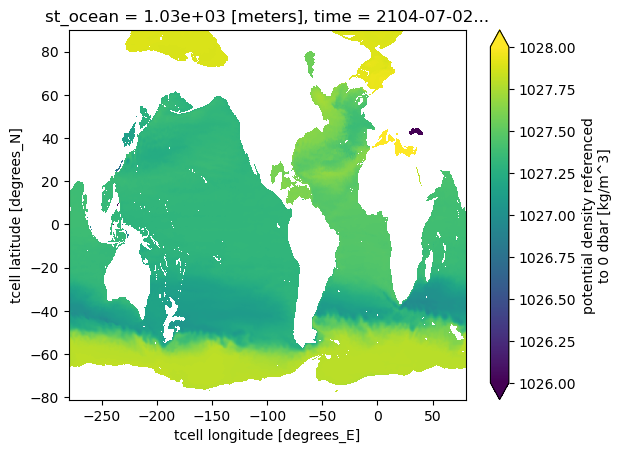

In [16]:
rho = ds[variable].isel(time=200).sel(st_ocean=1000, method='nearest')
rho.plot(vmin=1026, vmax=1028)

In addition, both `.sel` and `.isel` methods allow us to slice a range of values:

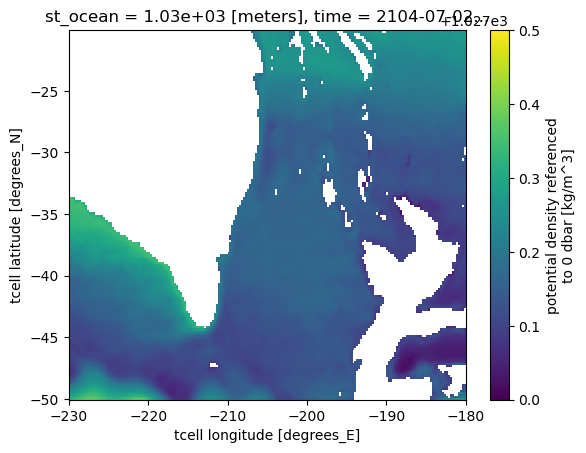

In [17]:
rho = ds[variable].isel(time=200).sel(st_ocean=1000, method='nearest').sel(xt_ocean=slice(-230, -180),
                                                                           yt_ocean=slice(-50, -20))
rho.plot(vmin=1027, vmax=1027.5)

Above, we have sliced out a small region of interest for our plot.

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean()` method to operate along given coordinates. The case below takes a temporal and zonal average of potential density.

#### IMPORTANT
To be precise, it is actually a numerical mean (in this case in the $i$-grid direction), which (a) doesn't account for the size of grid-cells and (b) is only zonal outside the tripolar region in the Arctic, i.e., *south of 65N* in the ACCESS-OM2 models. 

Issue (a) is not a problem for this particular case because the zonal length of cells is the same everywhere. However if you want to calculate a mean in the meridional dimension, or in depth, grid sizes are variable and you will need use these sizes as weights.

To address (b) and compute the zonal mean correctly one needs to be a bit more careful; see [`02-Appetisers/True_Zonal_Mean.ipynb`](https://cosima-recipes.readthedocs.io/en/latest/02-Appetisers/True_Zonal_Mean.html).

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


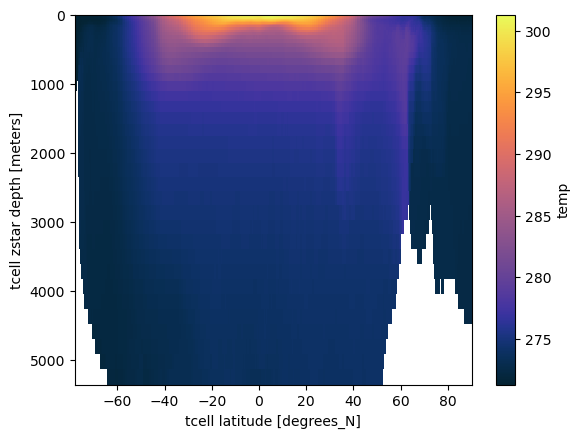

In [20]:
experiment = '1deg_jra55_iaf_omip2_cycle6'
variable = 'temp'

ds = catalog[experiment].search(variable=variable, frequency='1mon').to_dask(xarray_open_kwargs = dict(use_cftime=True))
ds[variable].mean(['time', 'xt_ocean']).plot(cmap=cm.cm.thermal)
plt.gca().invert_yaxis()

### 2.4 Resampling

`xarray` uses `datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful. Here is an example of re-plotting a monthly timeseries with annual averaging:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


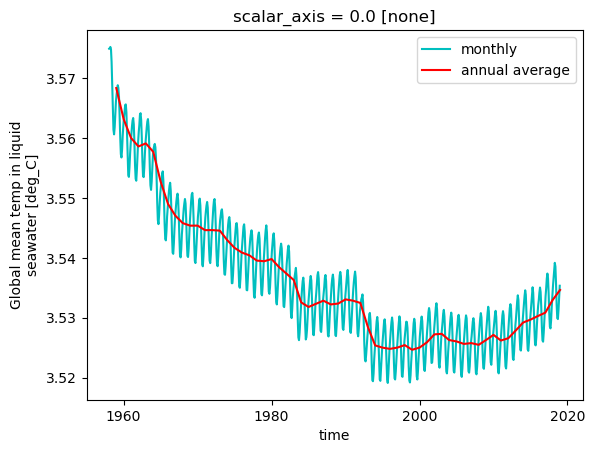

In [21]:
experiment = '1deg_jra55_iaf_omip2_cycle6'
variable = 'temp_global_ave'

ds = catalog[experiment].search(variable=variable, frequency='1mon').to_dask(xarray_open_kwargs = dict(use_cftime=True))
ds[variable].plot(color='c', label='monthly')

meandata = ds[variable].resample(time='YE').mean(dim='time')
meandata.plot(color='r', label='annual average')

plt.legend()

### 2.5 Exercises

 * Pick an experiment and plot a map of the temperature of the upper 100m of the ocean for one year.

 * Now, take the same experiment and construct a timeseries of spatially averaged (regional or global) upper 700m temperature, resampled every 3 years.